In [27]:
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import QuantileTransformer
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

In [28]:
with open('../data/05_model_input/cv_splits_dict.pkl/2020-08-28T04.48.19.250Z/cv_splits_dict.pkl', 'rb') as pkl_file:
    cv_splits_dict = pickle.load(pkl_file)
    
df_spatiotemporal = capacity_factors_daily_2000to2015 = pd.read_hdf(
    path_or_buf='../data/05_model_input/df_spatiotemporal.hdf', 
    key='df_spatiotemporal'
)

In [29]:
df_spatiotemporal['temporal'].columns.get_level_values('district')

Index(['DE111', 'DE114', 'DE115', 'DE116', 'DE118', 'DE119', 'DE11A', 'DE11B',
       'DE11C', 'DE11D',
       ...
       'DEG0E', 'DEG0F', 'DEG0G', 'DEG0I', 'DEG0J', 'DEG0K', 'DEG0L', 'DEG0M',
       'DEG0N', 'DEG0P'],
      dtype='object', name='district', length=292)

In [30]:
df_spatiotemporal['temporal']['DEF0C']

var,power
2013-01-01,0.298824
2013-01-02,0.277085
2013-01-03,0.561925
2013-01-04,0.603515
2013-01-05,0.139887
...,...
2015-12-27,0.652169
2015-12-28,0.313875
2015-12-29,0.591666
2015-12-30,0.460236


In [31]:
df = df_spatiotemporal['temporal'] 
# df.loc[ ~np.isfinite(df).any(1) ]
df.columns.to_series()[np.isinf(df).any()]

Series([], dtype: object)

In [32]:
display( df_spatiotemporal['temporal'].isna().sum().sum(),
         df_spatiotemporal['temporal'].size - np.isfinite( df_spatiotemporal['temporal'] ).sum().sum(),
       )

0

0

In [34]:
quantile_transformer = QuantileTransformer(
    output_distribution='normal', 
    random_state=0)

quantile_transformer = quantile_transformer.fit( 
    df_spatiotemporal['temporal'].loc[:'2014-12-31']
)

In [35]:
df_spatiotemporal['temporal'].transform()

TypeError: transform() missing 1 required positional argument: 'func'

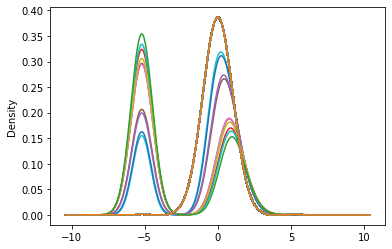

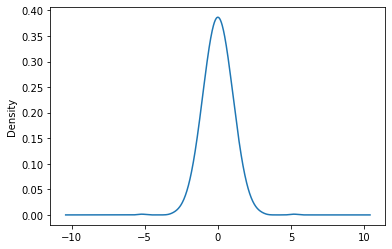

In [16]:
ax = df_spatiotemporal['temporal'].plot.density(legend=False)
ax2 = df_spatiotemporal['temporal']['DEF0C'].plot.density(legend=False)
plt.show()

In [17]:
def _split_train_test(df, cv_splits_dict, pass_id: str):
    train_idx_start = cv_splits_dict[pass_id]['train_idx'][0]
    train_idx_end = cv_splits_dict[pass_id]['train_idx'][1]

    test_idx_start = cv_splits_dict[pass_id]['test_idx'][0]
    test_idx_end = cv_splits_dict[pass_id]['test_idx'][1]

    return {
        'train': df.iloc[train_idx_start:train_idx_end, :],
        'test': df.iloc[test_idx_start:test_idx_end, :],
    }

In [11]:
y = _split_train_test(ts, cv_splits_dict, pass_id='pass_2')

display(y['train'], y['test'])

NameError: name 'ts' is not defined

In [ ]:
type( y['train']['power'] )

In [ ]:
model = {}
pred = {}
# for district in df_spatiotemporal['temporal'].columns.get_level_values('district'):
for district in ['DEF0C', 'DE111']:
    
    model[district] = {}
    pred[district] = {}
    ts = df_spatiotemporal['temporal'][district]
    
    for pass_id in cv_splits_dict.keys():
        
        y = _split_train_test(ts, cv_splits_dict, pass_id)
        
        model[district][pass_id] = ExponentialSmoothing(
            y['train']['power'], 
            trend='add',
            seasonal='mul',
            seasonal_periods=28,
        ).fit()
    
        pred[district][pass_id] = model[district][pass_id].predict(
            start=y['test']['power'].index[0],
            end=y['test']['power'].index[-1]
        )


In [ ]:
model['DEF0C']['pass_1'].forecast(8)

In [ ]:
ax = y['train']['power'].plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters' multiplicative method" )
ax.set_ylabel("Capacity Factor [-]")
model['DEF0C']['pass_1'].fittedvalues.plot(ax=ax, style='--', color='red')
plt.show()

In [ ]:
ax = y['train']['power'].plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters' multiplicative method" )
ax.set_ylabel("Capacity Factor [-]")
plt.show()

In [ ]:
y['train']['power'].plot.density()

In [ ]:
def logstandardize(x):
    logx = np.log(x)
    return (logx - logx.mean())/(logx.std())

y_preprocessed = logstandardize( y['train']['power'] )

ax = y_preprocessed.plot.density()
ax.axvline(x=y_preprocessed.mean())
plt.show()

In [ ]:
ax = y_preprocessed.plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters' multiplicative method" )
ax.set_ylabel("Capacity Factor [-]")
plt.show()

In [ ]:
tss = df_spatiotemporal['temporal']
tss_preprocessed = logstandardize( tss )

tss_preprocessed.plot.density()

In [ ]:
tss.plot.density()  # TODO: handle NaNs/Infs resulting from np.log(0)

In [ ]:
def logstandardize(x: pd.DataFrame):
    logx = np.log(x)
    
    transformation_factors = {
        'logx.mean': logx.mean(),
        'logx.std': logx.std()
    }
    return ( logx - logx.mean() ) / logx.std()
    # return {
    #    'transformed': (logx - logx.mean())/(logx.std()),
    #    'transformation_factors': transformation_factors
    #}

def make_positive(x):
    return x + abs(x.min())


def make_strictly_positive(x):
    return x + abs(x.min()) + 1E-16
    # return {
    #    'transformed': x + abs(x.min()) + 1E-12,
    #    'x.min': {'logxstd.min': x.min()},
    #}

tss = df_spatiotemporal['temporal']
tss_preprocessed = logstandardize( tss )
tss_preprocessed_positive = make_strictly_positive( tss_preprocessed ) 

In [ ]:
model = {}
pred = {}
# for district in df_spatiotemporal['temporal'].columns.get_level_values('district'):
for district in ['DEF0C', 'DE111']:
    
    model[district] = {}
    pred[district] = {}
    ts = tss_preprocessed_positive[district]
    
    for pass_id in cv_splits_dict.keys():
        
        y = _split_train_test(ts, cv_splits_dict, pass_id)
        
        model[district][pass_id] = ExponentialSmoothing(
            y['train']['power'], 
            trend='add',
            seasonal='mul',
            seasonal_periods=365,
        ).fit()
    
        pred[district][pass_id] = model[district][pass_id].predict(
            start=y['test']['power'].index[0],
            end=y['test']['power'].index[-1]
        )

def unscale():
    
    
ax = y['train']['power'].apply(np.exp).plot(figsize=(60,12), color='black',alpha=0.3, title="Forecasts from Holt-Winters' multiplicative method" )
ax.set_ylabel("Capacity Factor [-]")
#model['DEF0C']['pass_1'].fittedvalues.plot(ax=ax, style='-', color='red', alpha=0.5)
#model['DEF0C']['pass_2'].fittedvalues.plot(ax=ax, style='-', color='blue', alpha=0.5)
model['DEF0C']['pass_3'].fittedvalues.apply(np.exp).plot(ax=ax, style='-', color='green', alpha=0.5)
plt.show()

In [ ]:
y_quantiletransformed = quantile_transformer.fit_transform( tss['DEF0C'] )
y_quantiletransformed = pd.Series(
    y_quantiletransformed[:,0],
    index = tss.index
)

ax = y_quantiletransformed.plot.density()
ax.axvline(x=y_quantiletransformed.mean())
plt.show()